<a href="https://colab.research.google.com/github/eflores5000/08MIAR_APR/blob/main/proyecto_final_APR_V16_en_colab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.2. Localizar entorno de trabajo: Google colab o local

In [17]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False


## 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico  exists.

Colab: Changing directory to  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
Archivos en el directorio: 
['dqn_models', 'checkpoints', 'dqn_05_weights.h5f.data-00000-of-00001', 'dqn_05_weights.h5f.index', 'dqn_06_weights.h5f.index', 'dqn_06_weights.h5f.data-00000-of-00001', 'dqn_07_weights.h5f.index', 'dqn_07_weights.h5f.data-00000-of-00001', 'dqn_08_weights.h5f.data-00000-of-00001', 'dqn_08_weights.h5f.index', '.ipynb_checkpoints', 'dqn_09_weights.h5f.index', 'dqn_09_weights.h5f.data-00000-of-00001', 'dqn_06_1_weights.h5f.data-00000-of-00001', 'dqn_06_1_weights.h5f.index', 'video', 'dqn_06_3_weights.h5f.index', 'dqn_06

## 1.4. Instalar librerías necesarias

In [3]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12  #2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.05
  %pip install Keras==2.2.4
  %pip install tensorflow==2.1.0
  %pip install torch==2.0.1
  %pip install agents==1.4.0

  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-1gx75jne
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-1gx75jne
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done


## **PARTE 3**. Desarrollo y preguntas
Importar librerías

In [4]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Permute
#from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


#### Configuración base

In [5]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

height, width, channels = env.observation_space.shape
obs = env.reset()
print(height, width, channels)
print("Forma de la observación:", obs.shape)  # Debe ser (height, width, channels)
env.unwrapped.get_action_meanings()

210 160 3
Forma de la observación: (210, 160, 3)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


## 1. Implementación de la red neuronal

In [7]:
def build_model(height, width, channels, actions):

    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=(4, 84, 84)))  # WINDOW_LENGTH, H, W
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu')) #, input_shape=(4, 84, 84), data_format='channels_first')) #input_shape=(4,84,84,1)))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model

In [8]:
model = build_model(84, 84, 1, nb_actions)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 6)                 3

## 2. Implementación de la solución DQN

In [9]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [10]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps',
        value_max=1.0,
        value_min=0.1,
        value_test=0.05,
        nb_steps=400000)                    # Pasos de exploración

    memory = SequentialMemory(
        limit=400000,                       # Replay Buffer (Memoria de experiencias pasadas en total (s,a,r,s'))
        window_length=4)

    dqn = DQNAgent(model=model,
                   nb_actions=nb_actions,
                   policy=policy,
                   memory=memory,
                   processor=AtariProcessor(),
                   nb_steps_warmup=100000,    # Llena en buffer de pasos previos (s,a,r,s') sin evaluar aún.
                   gamma=0.99,
                   target_model_update=20000, # cada 10,000 steps actualiza la red objetivo
                   train_interval=4,          # Solo entrena cada n pasos de interacción con el entorno
                   delta_clip=1.0,            # Valor utilizado para recortar los errores TD (diferencia temporal) durante el entrenamiento para evitar fluctuaciones externas
                   enable_double_dqn=True,
                   enable_dueling_network=True,
                   dueling_type='avg',
                   batch_size=32,
                   )
    return dqn

In [11]:
from rl.callbacks import ModelIntervalCheckpoint

# Guardar el modelo cada 50,000 pasos
checkpoint_callback = ModelIntervalCheckpoint(
    filepath='checkpoints/dqn_v16_weights_{step}.h5f',
    interval=50000,
    verbose=1
)

In [12]:
import os
os.makedirs("checkpoints", exist_ok=True)

In [13]:
from keras.optimizers import Adam

dqn = build_agent(model, nb_actions)
dqn.compile(Adam(learning_rate=0.00025, epsilon=0.001))


In [14]:
from datetime import datetime

print(f"⏱ Tiempo de inicio: {datetime.now().strftime('%H:%M:%S')}")

dqn.fit(env, nb_steps=1250000, visualize=False, verbose=2,callbacks=[checkpoint_callback])

print(f"⏱ Tiempo de fin: {datetime.now().strftime('%H:%M:%S')}")

# Guardando modelo
dqn.save_weights('dqn_v16_weights.h5f')


⏱ Tiempo de inicio: 23:01:39
Training for 1250000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     625/1250000: episode: 1, duration: 2.629s, episode steps: 625, steps per second: 238, episode reward: 11.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.494 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
    1269/1250000: episode: 2, duration: 2.602s, episode steps: 644, steps per second: 248, episode reward:  8.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.402 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
    1924/1250000: episode: 3, duration: 2.648s, episode steps: 655, steps per second: 247, episode reward: 10.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.417 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
    2333/1250000: episode: 4, duration: 1.692s, episode steps: 409, steps per second: 242, episode reward:  6.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.362 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
    3057/1250000: episode: 5, duration: 2.978s, episode steps: 724, steps per second: 243, episode rewar

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  100414/1250000: episode: 137, duration: 13.096s, episode steps: 494, steps per second:  38, episode reward:  7.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.565 [0.000, 5.000],  loss: 0.004424, mean_q: 0.062596, mean_eps: 0.774532
  101076/1250000: episode: 138, duration: 19.553s, episode steps: 662, steps per second:  34, episode reward: 12.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.310 [0.000, 5.000],  loss: 0.006729, mean_q: 0.064816, mean_eps: 0.773326
  101615/1250000: episode: 139, duration: 15.945s, episode steps: 539, steps per second:  34, episode reward:  5.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 2.434 [0.000, 5.000],  loss: 0.005830, mean_q: 0.056881, mean_eps: 0.771976
  102385/1250000: episode: 140, duration: 22.553s, episode steps: 770, steps per second:  34, episode reward: 11.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.629 [0.000, 5.000],  loss: 0.005670, mean_q: 0.046797, mean_eps: 0.770500
  103339/1250000: ep

In [15]:
# Testing part to calculate the mean reward a los 500k
#weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
weights_filename = 'dqn_v16_weights.h5f'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 18.000, steps: 725
Episode 2: reward: 30.000, steps: 1100
Episode 3: reward: 47.000, steps: 1703
Episode 4: reward: 25.000, steps: 906
Episode 5: reward: 28.000, steps: 894
Episode 6: reward: 30.000, steps: 1091
Episode 7: reward: 24.000, steps: 834
Episode 8: reward: 28.000, steps: 876
Episode 9: reward: 29.000, steps: 1049
Episode 10: reward: 31.000, steps: 1110


In [19]:
import numpy as np
import random

#Número pruebas de validación
test = 5

print(f"Versión del fichero final: {weights_filename}")

medias = []

for i in range(1, test + 1):

    dqn.load_weights(weights_filename)
    # Ejecuta 10 episodios sin explorar (ε=0)
    hist = dqn.test(env, nb_episodes=10, visualize=False)

    # Calcula la media
    media = np.mean(hist.history["episode_reward"])
    medias.append(media)

    # Emite resultado
    print(f"Ejecución {i}: media = {media:.2f}\n")

n = sum(m >= 20 for m in medias)
print(f"{n} de {test} pruebas realizadas de 10 episodios cada una.")


Versión del fichero final: dqn_v16_weights.h5f
Testing for 10 episodes ...
Episode 1: reward: 20.000, steps: 792
Episode 2: reward: 31.000, steps: 1233
Episode 3: reward: 25.000, steps: 879
Episode 4: reward: 31.000, steps: 1407
Episode 5: reward: 23.000, steps: 794
Episode 6: reward: 22.000, steps: 894
Episode 7: reward: 35.000, steps: 1307
Episode 8: reward: 30.000, steps: 1044
Episode 9: reward: 23.000, steps: 816
Episode 10: reward: 35.000, steps: 1280
Ejecución 1: media = 27.50

Testing for 10 episodes ...
Episode 1: reward: 24.000, steps: 853
Episode 2: reward: 21.000, steps: 791
Episode 3: reward: 29.000, steps: 1024
Episode 4: reward: 25.000, steps: 798
Episode 5: reward: 31.000, steps: 1011
Episode 6: reward: 28.000, steps: 1047
Episode 7: reward: 21.000, steps: 807
Episode 8: reward: 15.000, steps: 521
Episode 9: reward: 25.000, steps: 825
Episode 10: reward: 31.000, steps: 1252
Ejecución 2: media = 25.00

Testing for 10 episodes ...
Episode 1: reward: 22.000, steps: 896
Epis

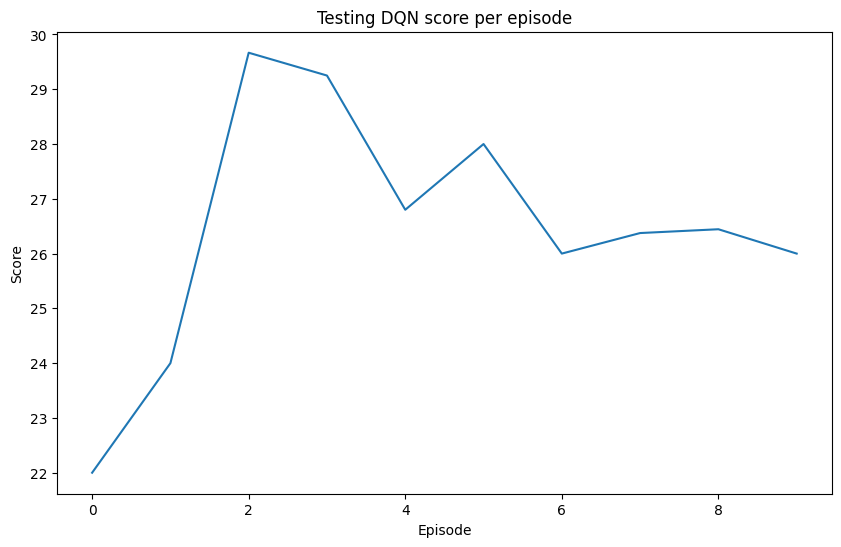

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

# plot score over episodes

plt.figure(figsize=(10,6))

# get moving average
episode_scores_dqn = hist.history["episode_reward"]
#episode_scores_dqn = stats['episode_scores']
N = len(episode_scores_dqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_dqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'Testing DQN score per episode')
#plt.savefig(plots_path + output_dir + f'{agent}_score_plot.png')
plt.show()